In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
def generate_open_close_signals(spx_data):
    PCTO_MIN = -1
    PCTO_MAX = 1
    PCTO_STEP = 0.5
    OTC_MIN = -1.5
    OTC_MAX = 1.5
    OTC_STEP = 0.25
    
    spx_data['Previous_Close_to_Open'] = np.clip((spx_data['Open'] - spx_data['Close'].shift(1)) / spx_data['Close'].shift(1) * 100, PCTO_MIN, PCTO_MAX)
    spx_data['Open_to_Close'] = np.clip((spx_data['Close'] - spx_data['Open']) / spx_data['Open'] * 100, OTC_MIN, OTC_MAX)
    
    signals = [None]*len(spx_data['Previous_Close_to_Open'])
    for i in range(1, len(spx_data['Previous_Close_to_Open'])):
        if spx_data['Previous_Close_to_Open'].iloc[i] >= 0.5 and spx_data['Open'][i] < spx_data['ema200'][i]:
            signals[i] = 'Buy'

    for i in range(1, len(spx_data['Previous_Close_to_Open'])):
        if spx_data['Previous_Close_to_Open'].iloc[i] <= -0.5 and spx_data['Open'][i] > spx_data['ema200'][i]:
            signals[i] = 'Sell'
    return signals

In [23]:
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
df_list = pd.read_html('https://finance.yahoo.com/world-indices/')
indices = df_list[0]
#tickers of major indices # {'ticker':'BTC', 'symbol':'BTC-USD'},
#for asset in asset_list:
asset_list = []
for i in range(0, 17):
    asset_dict = {}  # Initialize a new dictionary for each asset
    asset_dict['yfticker'] = indices.iloc[i, 0]
    asset_dict['name'] = indices.iloc[i, 1]
    asset_list.append(asset_dict)  # Append the dictionary to the list

In [46]:
indices = asset_list[0:10]
list_of_stock_data = []
for i in range(0,len(indices)):
    start_date = '2021-01-06'
    end_date = '2023-12-21'
    symbol = indices[i]['yfticker']
    temp_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
    #Determine the Buy signals
    temp_data["ema200"] = temp_data['Close'].ewm(span=80, adjust=False, min_periods=12).mean()
    temp_data['Signal'] = generate_open_close_signals(temp_data)
    list_of_stock_data.append(temp_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [47]:
indices

[{'yfticker': '^GSPC', 'name': 'S&P 500'},
 {'yfticker': '^DJI', 'name': 'Dow Jones Industrial Average'},
 {'yfticker': '^IXIC', 'name': 'NASDAQ Composite'},
 {'yfticker': '^NYA', 'name': 'NYSE COMPOSITE (DJ)'},
 {'yfticker': '^XAX', 'name': 'NYSE AMEX COMPOSITE INDEX'},
 {'yfticker': '^BUK100P', 'name': 'Cboe UK 100'},
 {'yfticker': '^RUT', 'name': 'Russell 2000'},
 {'yfticker': '^VIX', 'name': 'CBOE Volatility Index'},
 {'yfticker': '^FTSE', 'name': 'FTSE 100'},
 {'yfticker': '^GDAXI', 'name': 'DAX PERFORMANCE-INDEX'}]

In [44]:
initial_money = 10000
capital = 10000
list_of_stock_data[0]['equity'] = [None]*len(list_of_stock_data[0]['Close'])
#list_of_stock_data[0]["ema200"] = list_of_stock_data[0]['Close'].ewm(span=100, adjust=False, min_periods=12).mean()
spread = 0.0004
num_shares=0
final_balance=0
# Simulate buying and selling based on the generated signals
num_trades=0
leverage =10

for i in range(len( list_of_stock_data[0])):
    for j in range(0,len(indices)):
        divided=0
        for k in range(0,len(indices)):
            if list_of_stock_data[k]['Signal'][i] != None: 
                divided = divided +1
        if list_of_stock_data[j]['Signal'][i] == 'Buy':
            num_shares= (initial_money/list_of_stock_data[j]['Open'][i]*leverage)/divided
            initial_money = initial_money - (num_shares*list_of_stock_data[j]['Open'][i])
            initial_money = initial_money - (spread*num_shares*list_of_stock_data[j]['Open'][i])
            num_trades=num_trades+1
            initial_money= initial_money+ (num_shares*list_of_stock_data[j]['Close'][i])
       
        if list_of_stock_data[j]['Signal'][i] == 'Sell':
                num_shares= (initial_money/list_of_stock_data[j]['Open'][i]*leverage)/divided
                initial_money = initial_money + (num_shares*list_of_stock_data[j]['Open'][i])
                initial_money = initial_money - (spread*num_shares*list_of_stock_data[j]['Open'][i])
                num_trades=num_trades+1
                initial_money= initial_money- (num_shares*list_of_stock_data[j]['Close'][i])
        
        list_of_stock_data[0]['equity'][i]= initial_money

# Calculate the final balance based on the last stock price and remaining number of shares
totalreturn = (initial_money-capital)/capital*100
# Print the final balance and profit/loss
print(f"final_balance: {   initial_money:.2f} $")
print(f"Profit/Loss:  {initial_money - capital:.2f} $")
print(f"Total return: {totalreturn:.2f} %")
print(f"Total trades: {num_trades:} ")

final_balance: 10549.95 $
Profit/Loss:  549.95 $
Total return: 5.50 %
Total trades: 239 


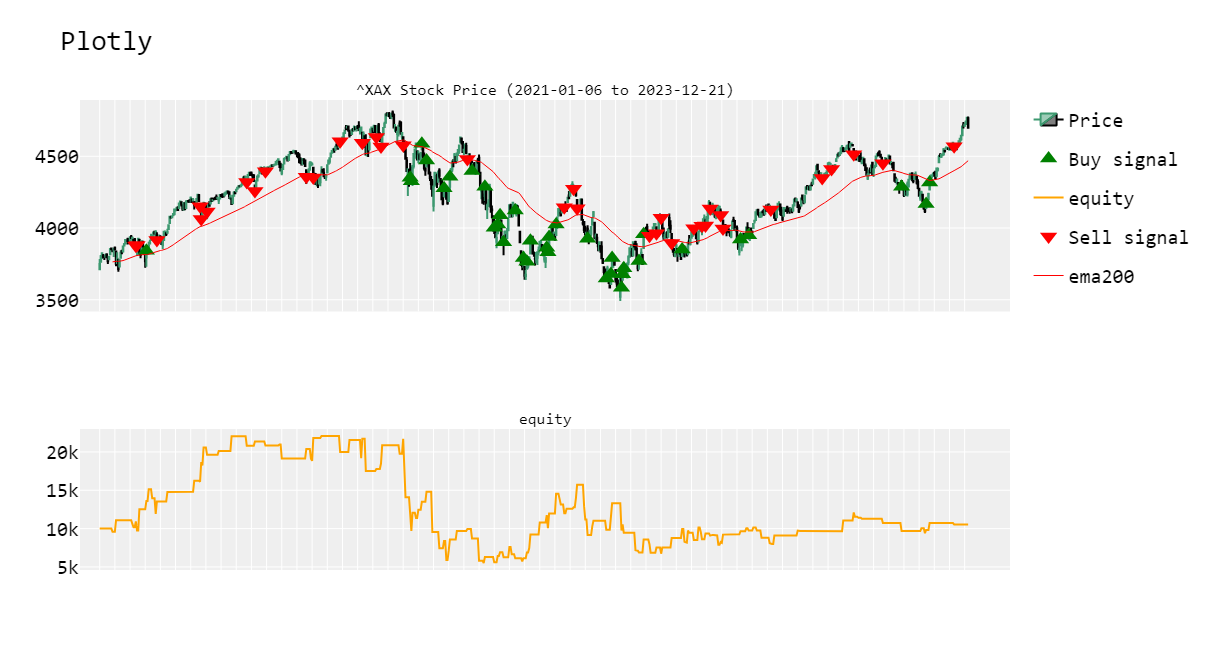

In [45]:
%run "C:\\Users\\adamj\\Documents\\Projekty_Python\\Quant_trading\\Plotting_backtesting.ipynb"
ploting_results_vectorbt_openclose(list_of_stock_data[0])